In [1]:
import numpy as np
import os
import pickle
from datasets.XP2 import Xp2Dataset
from datasets.utils import plot_on_topomap, select_grid_results_by_metric, plot_channel_coefficients
from models.efp import mh_grid_search, mh_common_model
import pandas as pd

import seaborn as sns

/home/riccardo/Projects/EEG-fMRI_fusion/models/clustering.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
base_folder = '/home/riccardo/MHdatasets'
stockwell_folder = '/media/storage1/stockwells'
out_folder = '/home/riccardo/MHdatasets/saves'
roi_str =  'm1'
root = os.path.join(base_folder,'XP2')
window_type='kazemi'
gamma=15
fmax = 60
n_bands = 12
workers = 15

dataset_unibands = Xp2Dataset(root, os.path.join(base_folder, f'dataset_MH_uniband_a{fmax}_{n_bands}_{window_type}_{gamma}.p'))
dataset_unibands.get_eeg_data(False)
shared_bands = dataset_unibands.get_dataset_shared_bands(fmax=fmax, num_bands=n_bands)
dataset_unibands.get_mh_features_and_targets(nf_key_bold=('roimean', 'bgmean'), 
                                    fmax=fmax,
                                    n_bands=n_bands,
                                    overwrite=False,
                                    workers=workers,
                                    band_boundaries=shared_bands,
                                    save_folder=stockwell_folder,
                                    base_freq_grid_size=500,
                                    gamma=gamma,
                                    window_type=window_type,
                                            )

Effective window size : 10.240 (s)
Starting workers and distributing tasks...


Preparing features and targets...: 100%|███████████████████████████████████████████████████████████████| 44/44 [00:00<00:00, 999.38it/s]


In [3]:
delay_time_seconds = 12
target_str = f'target_{roi_str}'
default_subject=1
subject=default_subject
test_ratio=.2
regularization_grid_search=50
overwrite=True

In [4]:
all_grid_search_results_unibands, all_models_unibands, grouped_unibands = mh_grid_search(
    dataset_unibands, f'{out_folder}/all_grid_search_results_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}_samebands.p',
    f'{out_folder}/all_models_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}_samebands.p',
    target_str=target_str,
    test_ratio=test_ratio,
    delay_time_seconds=delay_time_seconds,
)

In [5]:
grouped_corr = all_grid_search_results_unibands.groupby('channel').mean()

grouped_corr.sort_values('pearson r test', ascending=False).iloc[:10]

,pearson r test,pearson p test,MSE test,nMSE test,r2 test,MSE val,r2 val,pearson val,subject
channel,,,,,,,,,
CPz,0.419562,0.046664,0.990250,0.980615,-0.005423,3.441129,-9.062024,0.230520,20.878049
CP1,0.392083,0.052268,1.001206,0.984537,-0.003515,3.402599,-8.587456,0.266852,20.878049
TP8,0.377580,0.090085,1.061119,1.050818,-0.076523,3.772131,-12.922398,0.190482,20.878049
P5,0.374358,0.018667,1.045212,1.034448,-0.059355,3.495055,-16.016557,0.217124,20.878049
CP3,0.368970,0.050407,1.020092,1.004757,-0.024235,3.289776,-11.840036,0.233185,20.878049
P3,0.368547,0.050074,1.020722,1.006226,-0.026901,3.582333,-8.665543,0.211086,20.878049
P2,0.365978,0.108778,1.033192,1.026152,-0.056625,4.004576,-11.358109,0.181223,20.878049
P1,0.365535,0.035321,1.018592,1.003678,-0.023550,3.825542,-7.984137,0.248083,20.878049
PO4,0.358077,0.040276,1.039480,1.026896,-0.051733,3.725463,-8.880185,0.210701,20.878049


Using order based on dataframe channel info


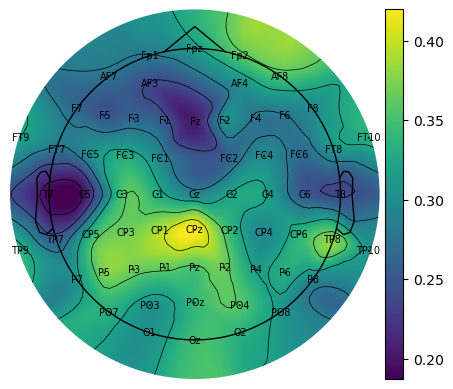

In [6]:
grouped_corr = all_grid_search_results_unibands.groupby('channel').mean()
plot_on_topomap(grouped_corr['pearson r test'], dataset_unibands[0])

Subjects:
[np.int64(0), np.int64(1), np.int64(3), np.int64(4), np.int64(7), np.int64(11), np.int64(12), np.int64(13), np.int64(20), np.int64(21), np.int64(22), np.int64(36), np.int64(37), np.int64(41), np.int64(42), np.int64(43)]
len: 16, 36.4% of the total.
Max mean correlation channel: CP1
Using order based on dataframe channel info


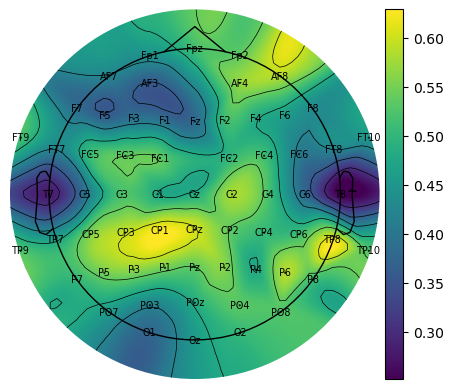

In [7]:
included_subjects_uniband, channel_name_uniband = select_grid_results_by_metric(all_grid_search_results_unibands, dataset_unibands, corr_cutoff = 0.47, selection_metric = 'pearson val') 

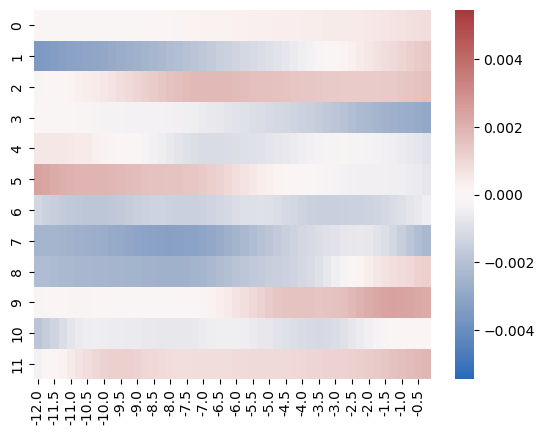

In [8]:
plot_channel_coefficients(included_subjects_uniband, dataset_unibands, 'CPz', all_models_unibands, n_bands=n_bands)

In [9]:
interesting_electrodes = ['CP1', 'CPz']

In [10]:
savefile = f'{out_folder}/full_dataset_models_a{roi_str}_{fmax}_{n_bands}_{window_type}_{gamma}.p'
if not os.path.exists(savefile):
    everything_results = {}
else:
    everything_results = pickle.load(open(savefile, 'rb'))
    
accepted_indexes = []
for s, subj in enumerate(dataset_unibands.dataset):
    if subj['mh_features'].shape[-1] == subj[target_str].shape[-1]:
        accepted_indexes.append(s)
valid_samples = dataset_unibands.get_subsample(accepted_indexes)

for channel in interesting_electrodes:
    if channel not in everything_results:
        common_model_results, _ = mh_common_model(valid_samples, None, channel, target_str)
        everything_results[channel] = common_model_results
pickle.dump(everything_results, open(savefile, 'wb'))


full_dataset_results = []
for electrode, res in everything_results.items():
    for r in res:
        r['electrode'] = electrode
    full_dataset_results.extend(res)
full_dataset_results = pd.DataFrame(full_dataset_results)
full_dataset_results

,pearson r test,pearson p test,MSE test,nMSE test,r2 test,MSE val,r2 val,pearson val,electrode
0,0.378744,2.632687e-43,0.905098,0.900204,0.104664,0.978363,0.023017,0.195638,CP1
1,0.333278,2.418560e-33,0.840609,0.875837,0.087459,0.980538,0.021036,0.192255,CP1
2,0.268227,9.586545e-22,0.938323,0.937269,0.063783,0.977365,0.023252,0.198208,CP1
3,-0.090390,1.493416e-03,1.094844,1.097520,-0.100203,0.971389,0.027807,0.205321,CP1
4,0.022949,4.209425e-01,1.034040,1.040295,-0.046587,0.972024,0.027596,0.204968,CP1
...,...,...,...,...,...,...,...,...,...
77,0.485391,8.131934e-74,0.805730,0.811654,0.182378,0.956664,0.043065,0.234007,CPz
78,0.351789,3.332601e-37,0.905814,0.895692,0.114317,0.956260,0.043866,0.235192,CPz
79,0.271423,3.017484e-22,0.929838,0.930204,0.069429,0.949185,0.048471,0.243314,CPz
80,0.335547,8.401470e-34,0.919104,0.903345,0.112144,0.949185,0.048471,0.243314,CPz


<Axes: xlabel='electrode', ylabel='pearson r test'>

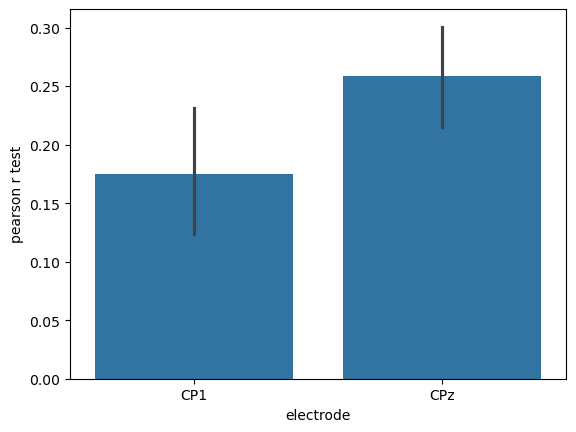

In [11]:
sns.barplot(data=full_dataset_results, x='electrode', y='pearson r test')

In [16]:
full_dataset_results.to_pickle('M1_12_bars.pickle')

In [14]:
np.array(full_dataset_results[full_dataset_results['electrode'] == 'CPz']['pearson r test'])

array([ 0.35545314,  0.23495148,  0.28513794,  0.1850495 ,  0.28833662,
        0.23193964,  0.34174873,  0.28387688, -0.14029723, -0.10427287,
        0.07808072,  0.53893461,  0.54880966,  0.37793697,  0.26866327,
        0.16681576,  0.20416   ,  0.35179994,  0.06911254,  0.38553678,
        0.27547934,  0.29525502,  0.17937514,  0.11731851,  0.15126213,
        0.01406354,  0.38383393,  0.31767948,  0.28031883,  0.31897454,
        0.08601756,  0.16852062,  0.24273712,  0.35742352,  0.28592475,
        0.39410726,  0.48539144,  0.3517887 ,  0.27142349,  0.33554686,
        0.32388781])